In [8]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))
from os.path import expanduser

%load_ext autoreload
%autoreload 2

from dotenv import load_dotenv
load_dotenv()

from google.cloud import storage
from project_config import GCP_PROJECT_NAME, DATASET_JSON_PATH

gcp_client = storage.Client(project=GCP_PROJECT_NAME)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import os, torch
 #to prevent cuda out of memory error
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"


#For reproducibility
torch.manual_seed(13)



### Configuration

In [10]:
from experiment_configs.configs import *
config = satmae_large_config_lora
# config.finetuning_strategy

### Create Rastervision datasets

In [11]:
from torch.utils.data import ConcatDataset
import json
from utils.rastervision_pipeline import observation_to_scene, scene_to_training_ds, scene_to_validation_ds, scene_to_inference_ds
from utils.data_management import observation_factory, characterize_dataset
import random

#set the seed
random.seed(13)

# get the current working directory
root_dir = os.getcwd()

# define the relative path to the dataset JSON file
json_rel_path = '../' + DATASET_JSON_PATH

# combine the root directory with the relative path
json_abs_path = os.path.join(root_dir, json_rel_path)

dataset_json = json.load(open(json_abs_path, 'r'))
all_observations = observation_factory(dataset_json)

#find the highest cluster id
max_cluster_id = max([observation['cluster_id'] for observation in dataset_json])


# Randomly split the data into training and validation
val_split = random.randint(0, max_cluster_id+1)

training_scenes = []
validation_scenes = []

for observation in all_observations:
    if observation.cluster_id == val_split: 
        validation_scenes.append(observation_to_scene(config, observation))
    else:
        training_scenes.append(observation_to_scene(config, observation))


training_datasets = [
    scene_to_training_ds(config, scene) for scene in training_scenes #random window sampling happens here
]
validation_datasets = [
    # scene_to_validation_ds(config, scene) for scene in validation_scenes
    scene_to_inference_ds(config, scene, full_image=False, stride=int(config.tile_size/2)) for scene in validation_scenes # better performance with this
]

train_dataset_merged = ConcatDataset(training_datasets)
val_dataset_merged = ConcatDataset(validation_datasets)

print('Validation split cluster_id:', val_split)
print ('Training dataset size: {:4d} images | Number of observations: {:}'.format(len(train_dataset_merged), len(training_scenes)))
print ('Testing dataset size: {:4d}  images | Number of observations: {:}'.format(len(val_dataset_merged), len(validation_scenes)))

mine_percentage_aoi = characterize_dataset(training_scenes, validation_scenes)

2023-12-23 19:27:44:rastervision.pipeline.file_system.utils: INFO - Using cached file /data/tmp/cache/http/storage.googleapis.com/sand_mining_median/labels/Kathajodi_Cuttack_85-85_20-44_median/s2/Kathajodi_Cuttack_85-85_20-44_2022-05-01_s2.tif.
2023-12-23 19:27:44:rastervision.pipeline.file_system.utils: INFO - Using cached file /data/tmp/cache/http/storage.googleapis.com/sand_mining_median/labels/Kathajodi_Cuttack_85-85_20-44_median/annotations/Kathajodi_Cuttack_85-85_20-44_2022-05-01_annotations.geojson.
2023-12-23 19:27:44:rastervision.pipeline.file_system.utils: INFO - Using cached file /data/tmp/cache/http/storage.googleapis.com/sand_mining_median/labels/Kathajodi_Cuttack_85-85_20-44_median/rivers/Kathajodi_Cuttack_85-85_20-44_rivers_1000m.geojson.
2023-12-23 19:27:44:rastervision.core.data.vector_source.geojson_vector_source: INFO - Ignoring CRS ({'type': 'name', 'properties': {'name': 'urn:ogc:def:crs:OGC:1.3:CRS84'}}) specified in https://storage.googleapis.com/sand_mining_medi

Validation split cluster_id: 4
Training dataset size: 2008 images | Number of observations: 72
Testing dataset size: 1006  images | Number of observations: 8
Total dataset has 2.93%  mining area.
Training dataset has 3.05%  mining area.
Validation dataset has 2.15%  mining area.
Within AOIs, total dataset has 6.72%  mining area.
Outside AOIs, total dataset has 0.06%  mining area.

The median percentage of mine in an observation is 3.26%
The median number of mine pixels in an observation is 38059

The median number pixels in an observation is 1301008


## Update the loss weights to account for the imbalanced dataset

In [12]:
# config.mine_class_loss_weight = (100 - mine_percentage_aoi) / mine_percentage_aoi
# config.mine_class_loss_weight = 1
config.mine_class_loss_weight

6.0

## Visualize the datasets

In [13]:
from utils.visualizing import visualize_dataset

# print ('Training Dataset')
# for ds in training_datasets:
#     visualize_dataset(ds)

print("\n\n\n Val Dataset")

# for ds in validation_datasets:
#     visualize_dataset(ds)




 Val Dataset


# Train

In [14]:
from models.model_factory import model_factory, print_trainable_parameters
from ml.optimizer_factory import optimizer_factory
from ml.learner import BinarySegmentationLearner

_, _, n_channels = training_datasets[0].scene.raster_source.shape
model = model_factory(
    config,
    n_channels=n_channels,
)

print("Before LoRA: ")
print_trainable_parameters(model)


from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["qkv"],
    lora_dropout=0.1,
    bias="none",
    modules_to_save=["decoder"], #modules_to_save: List of modules apart from LoRA layers to be set as trainable and saved in the final checkpoint. These typically include model’s custom head that is randomly initialized for the fine-tuning task.
)

model = get_peft_model(model, lora_config)

optimizer = optimizer_factory(config, model)

learner = BinarySegmentationLearner(
    config=config,
    model=model,
    optimizer=optimizer,
    train_ds=train_dataset_merged,  # for development and debugging, use training_datasets[0] or similar to speed up
    valid_ds=val_dataset_merged,  # for development and debugging, use training_datasets[1] or similar to speed up
    output_dir=expanduser("~/sandmining-watch/out/OUTPUT_DIR"),
)

print_trainable_parameters(learner.model)

SatMae: Loading encoder weights from /data/sand_mining/checkpoints/satmae_orig/pretrain-vit-large-e199.pth
Position interpolate from 12x12 to 25x25
Warning! Missing keys:
['channel_cls_embed', 'head.weight', 'head.bias']
SatMaePretrained: Freezing encoder weights
Number of parameters loaded: 298
Before LoRA: 
trainable params: 1.106945M || all params: 304.561667M || trainable%: 0.36


2023-12-23 19:27:58:rastervision: INFO - train_ds: 2008 items
2023-12-23 19:27:58:rastervision: INFO - valid_ds: 1006 items


trainable params: 2.679809M || all params: 307.241476M || trainable%: 0.87


#### Check GPU Activity

You can continuously monitor your GPU activity by using the command in the terminal


`watch -d -n 0.5 nvidia-smi`

In [11]:
import wandb
wandb.login(relogin=True)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wand

In [8]:
# Run this cell if you want to log the run to W&B. You might need to authenticate to W&B.
learner.initialize_wandb_run()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


Problem at: /home/ando/sandmining-watch/ml/learner.py 493 initialize_wandb_run


KeyboardInterrupt: 

wandb: Network error (ReadTimeout), entering retry loop.


In [17]:
torch.cuda.memory_reserved() / 1e9, torch.cuda.memory_allocated() / 1e9, torch.cuda.max_memory_allocated() / 1e9, torch.cuda.memory_cached() / 1e9

(1.256194048, 1.229141504, 2.458108928, 1.256194048)

In [16]:
import gc
import torch
gc.collect()
torch.cuda.empty_cache()

In [18]:
learner.train(epochs=5)

2023-12-23 19:28:30:rastervision: INFO - epoch: 0


Training:   0%|          | 0/502 [00:00<?, ?it/s]

Validating:   0%|          | 0/252 [00:00<?, ?it/s]

2023-12-23 19:44:58:rastervision: INFO - metrics:
{'avg_f1': 0.9651647806167603,
 'avg_precision': 0.9738522171974182,
 'avg_recall': 0.9566310048103333,
 'epoch': 0,
 'other_f1': 0.9773016571998596,
 'other_precision': 0.992146909236908,
 'other_recall': 0.9628941416740417,
 'sandmine_average_precision': 0.5673260028465247,
 'sandmine_best_f1_score': 0.5445477854451168,
 'sandmine_best_threshold': 0.60785437,
 'sandmine_f1': 0.5145111680030823,
 'sandmine_precision': 0.38977113366127014,
 'sandmine_recall': 0.756672203540802,
 'train_bce_loss': 0.13343820153954494,
 'train_dice_loss': 0.2125433811628486,
 'train_time': datetime.timedelta(seconds=793, microseconds=762087),
 'val_bce_loss': 0.05386143982054936,
 'val_dice_loss': 0.21943016886474123,
 'valid_time': datetime.timedelta(seconds=194, microseconds=304549)}
2023-12-23 19:44:58:rastervision: INFO - epoch: 1


Best Threshold=0.607854, Best F1 Score=0.545


Training:   0%|          | 0/502 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Merge LoRA layers into the main model

In [19]:
print("Before merge: ")
print_trainable_parameters(learner.model)

learner.model = learner.model.merge_and_unload(safe_merge=True)
learner.save_model_weights(learner.last_model_weights_path)

print("After merge: ")
print_trainable_parameters(learner.model)


Before merge: 
trainable params: 2.679809M || all params: 307.241476M || trainable%: 0.87
Saving model weights to /home/ando/sandmining-watch/out/OUTPUT_DIR/last-model.pth
After merge: 
trainable params: 1.106945M || all params: 304.561667M || trainable%: 0.36


CUDA out of memory. Tried to allocate 1.68 GiB (GPU 0; 31.74 GiB total capacity; 30.65 GiB already allocated; 695.06 MiB free; 30.68 GiB reserved in total by PyTorch) -> end2end, 8

CUDA out of memory. Tried to allocate 1.68 GiB (GPU 0; 31.74 GiB total capacity; 30.65 GiB already allocated; 695.06 MiB free; 30.68 GiB reserved in total by PyTorch) -> fine-tune, 8


## Evaluate 

Initialize evaluation_datasets and predictor.
evaluation_datasets and validation_datasets are based on identical scenes, but have different sliding window configurations.

In [20]:
config = satmae_large_inf_config
# config.tile_size = 200 #force to the same size as fine-tuning

In [21]:
from ml.learner import BinarySegmentationPredictor
# from utils.rastervision_pipeline import scene_to_inference_ds

# evaluation_datasets =  [
#     scene_to_inference_ds(
#         config, scene, full_image=True
#     ) for scene in validation_scenes
# ]

predictor = BinarySegmentationPredictor(
    config,
    learner.model
    )



Temperature scaling set to None


  0%|          | 0/8 [00:00<?, ?it/s]

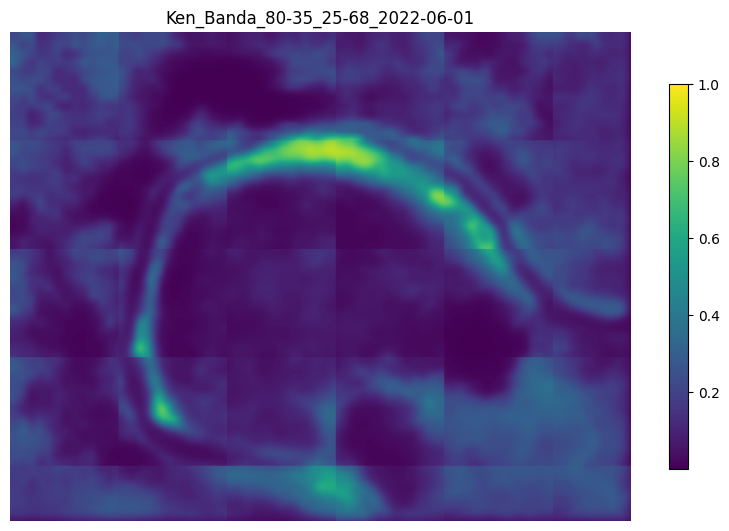

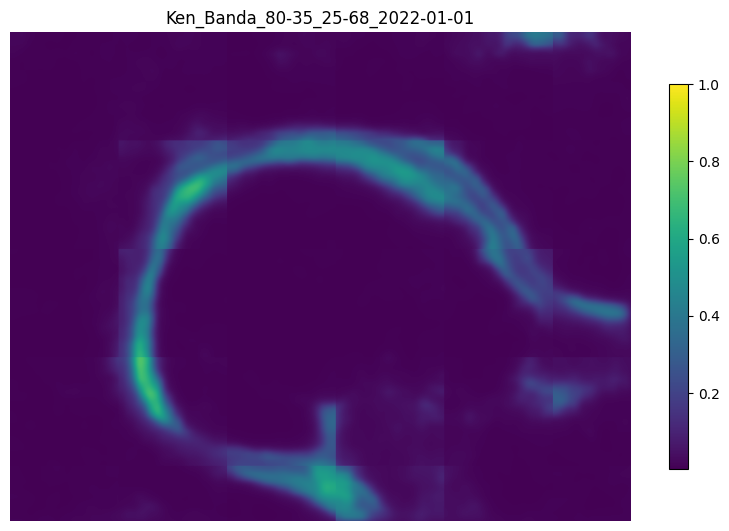

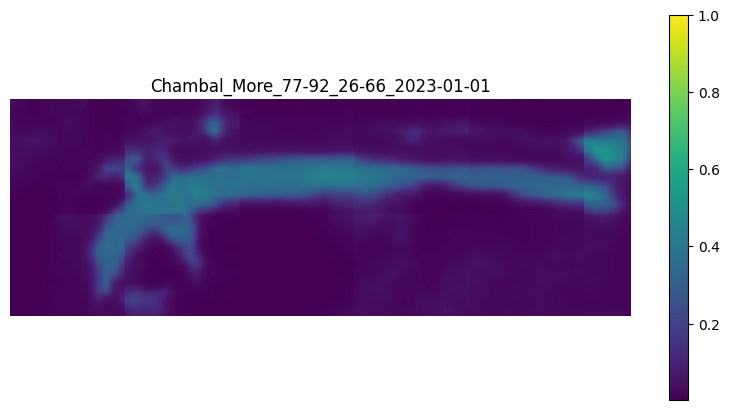

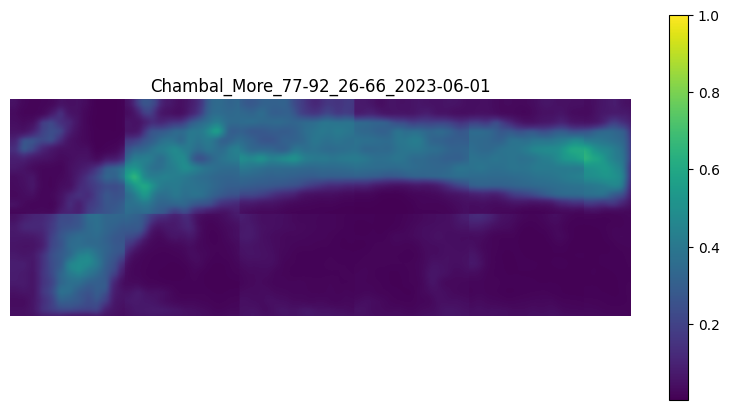

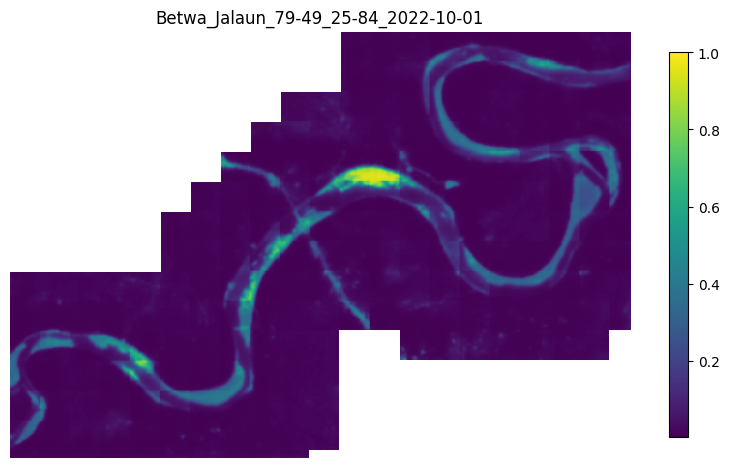

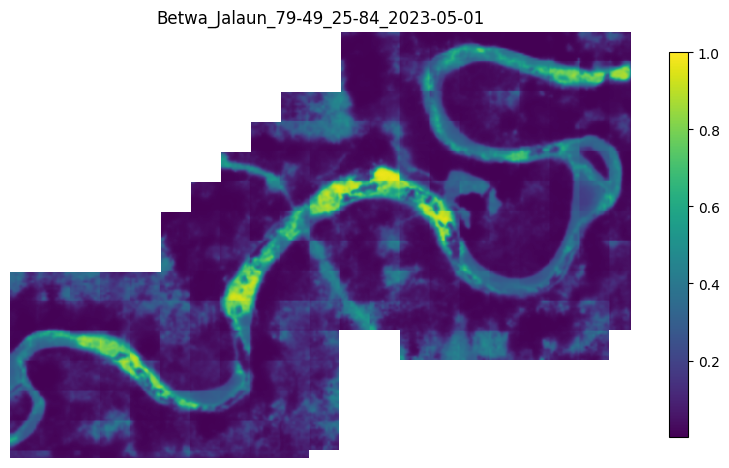

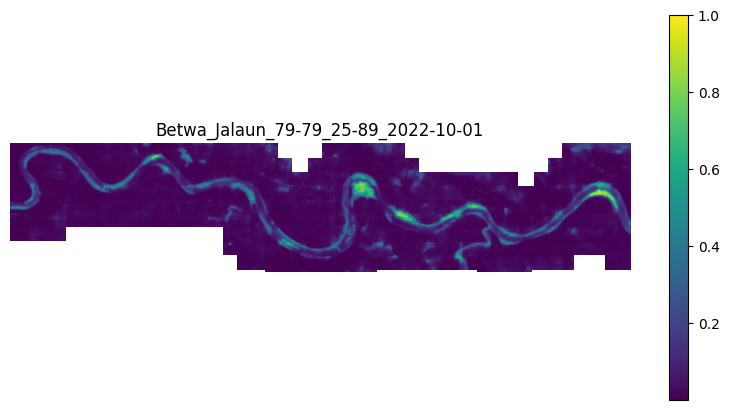

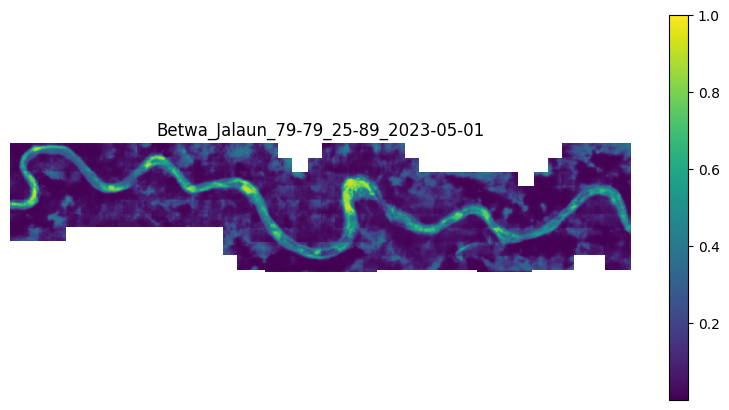

Best Threshold=0.423828, Best F1 Score=0.710
Best Threshold=0.333008, Best F1 Score=0.709
Best Threshold=0.444580, Best F1 Score=nan
Best Threshold=0.504883, Best F1 Score=nan
Best Threshold=0.440186, Best F1 Score=0.737
Best Threshold=0.600586, Best F1 Score=0.646
Best Threshold=0.415527, Best F1 Score=0.639
Best Threshold=0.475098, Best F1 Score=0.537
Best Threshold=0.467041, Best F1 Score=0.572


In [22]:
from utils.visualizing import raster_source_to_rgb
from tqdm.notebook import tqdm
from ml.eval_utils import evaluate_predictions
import matplotlib.pyplot as plt

prediction_results_list = []
predictions = []

for ds in tqdm(validation_datasets):


    prediction = predictor.predict_site(ds, crop_sz=config.crop_sz) 
    #store predictions for later (to save as GeoTIFFs):
    predictions.append(prediction)

    # grab the prob arrays
    prediction_score = prediction.get_score_arr(prediction.extent)[0]

    rgb_img = raster_source_to_rgb(ds.scene.raster_source)
    prediction_results_list.append({
        "predictions": prediction_score,
        "ground_truth": ds.scene.label_source.get_label_arr(),
        "rgb_img": rgb_img,
        "name": ds.scene.id,
        "crop_sz": config.crop_sz,
    })

    #if prediction_score has any nan values, set them to -1
    # prediction_score = prediction_score.copy()
    # prediction_score[np.isnan(prediction_score)] = -1.

    
    #Now viz
    plt.figure(figsize=(10, 10))
    plt.imshow(prediction_score, vmax=1, cmap='viridis') 
    plt.axis('off')
    plt.title(ds.scene.id)
    #show colorbar at half scale
    plt.colorbar(shrink=0.5)
    plt.show()

evaluation_results_dict = evaluate_predictions(prediction_results_list)

# Old results

## Pick the threshold that maximizes F1 score

In [23]:
threshold = evaluation_results_dict['eval/total/best_threshold']
threshold

0.467

In [24]:
evaluation_results_dict


{'eval/Ken_Banda_80-35_25-68_2022-06-01/precision': 0.8250523795270877,
 'eval/Ken_Banda_80-35_25-68_2022-06-01/recall': 0.5594682362492389,
 'eval/Ken_Banda_80-35_25-68_2022-06-01/f1_score': 0.6667876149008225,
 'eval/Ken_Banda_80-35_25-68_2022-06-01/average_precision': 0.7426648588857319,
 'eval/Ken_Banda_80-35_25-68_2022-06-01/best_threshold': 0.4238,
 'eval/Ken_Banda_80-35_25-68_2022-06-01/best_f1_score': 0.7101977107180022,
 'eval/Ken_Banda_80-35_25-68_2022-01-01/precision': 0.7192322167858487,
 'eval/Ken_Banda_80-35_25-68_2022-01-01/recall': 0.1847983753988976,
 'eval/Ken_Banda_80-35_25-68_2022-01-01/f1_score': 0.2940452377288814,
 'eval/Ken_Banda_80-35_25-68_2022-01-01/average_precision': 0.7073376787424815,
 'eval/Ken_Banda_80-35_25-68_2022-01-01/best_threshold': 0.333,
 'eval/Ken_Banda_80-35_25-68_2022-01-01/best_f1_score': 0.7087012468385322,
 'eval/Chambal_More_77-92_26-66_2023-01-01/precision': 0.0,
 'eval/Chambal_More_77-92_26-66_2023-01-01/recall': 0.0,
 'eval/Chambal_Mor

Log results to Weights & Biases

In [44]:
import wandb
from ml.eval_utils import make_wandb_segmentation_masks, make_wandb_predicted_probs_images

assert wandb.run is not None

# Add lists of W&B images to dict
evaluation_results_dict.update({
    'Segmentation masks': make_wandb_segmentation_masks(prediction_results_list, threshold),
    'Predicted probabilites': make_wandb_predicted_probs_images(prediction_results_list),
})

# Log to W&B
wandb.log(evaluation_results_dict)

In [45]:
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


eval/Betwa_Jalaun_79-49_25-84_2022-10-01/average_precision,▁
eval/Betwa_Jalaun_79-49_25-84_2022-10-01/best_f1_score,▁
eval/Betwa_Jalaun_79-49_25-84_2022-10-01/best_threshold,▁
eval/Betwa_Jalaun_79-49_25-84_2022-10-01/f1_score,▁
eval/Betwa_Jalaun_79-49_25-84_2022-10-01/precision,▁
eval/Betwa_Jalaun_79-49_25-84_2022-10-01/recall,▁
eval/Betwa_Jalaun_79-49_25-84_2023-05-01/average_precision,▁
eval/Betwa_Jalaun_79-49_25-84_2023-05-01/best_f1_score,▁
eval/Betwa_Jalaun_79-49_25-84_2023-05-01/best_threshold,▁
eval/Betwa_Jalaun_79-49_25-84_2023-05-01/f1_score,▁
eval/Betwa_Jalaun_79-49_25-84_2023-05-01/precision,▁
